# **Digital Signal and Image Management - 1D Signal Processing**<br/>

---

#Human Activity Recognition using Smartphone Accelerometer Data

Authors:

Luca Galli - 905236 | Davide Ronchi - 903320

---



# Contents

This notebook aims to explore and implement various machine learning techniques for **Human Activity Recognition** using smartphone sensor data. The dataset used is the [**WISDM dataset**](https://www.cis.fordham.edu/wisdm/dataset.php), that contains accelerometer readings from smartphones worn by individuals performing different activities like walking, jogging, sitting, etc.

The notebook covers the following aspects:
* Cleaning and formatting of data columns, values and units of measurement
* Data aggregation and exploratory analysis
* Resampling from non-constant samples to fixed 20Hz sampling rate using cubic splines
* Export the preprocessed dataset, which will be used in the following notebooks

# Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.io import arff
import os
from io import StringIO
import re
import seaborn as sns
from tqdm import tqdm
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Format

We first import the dataset (raw txt format), convert the time unit to seconds, clean the data, remove duplicates, and make sure that all singnals start from time 0.

In [ ]:
def compute_gtot(dataframe):
    gtot = np.sqrt(np.square(dataframe['gFx']) + np.square(dataframe['gFy']) + np.square(dataframe['gFz']))
    return gtot

In [ ]:
wisdm_df = pd.read_csv('/content/drive/MyDrive/DSaIM_project/1D/Materials/WISDM_ar_v1.1_raw.txt', header=None, names=['user', 'activity', 'timestamp', 'x-acceleration', 'y-acceleration', 'z-acceleration'], sep=',')
wisdm_df = wisdm_df.dropna()
wisdm_df = wisdm_df[wisdm_df['timestamp'] != 0]
wisdm_df['z-acceleration'] = wisdm_df['z-acceleration'].str.rstrip(';').astype('float')
wisdm_df['activity'] = wisdm_df['activity'].str.lower()
wisdm_df['timestamp'] = wisdm_df['timestamp'] / 1e9
wisdm_df = pd.DataFrame(wisdm_df)
wisdm_df.sort_values(by=['user', 'activity', 'timestamp'], inplace=True)


wisdm_df['timestamp'] = wisdm_df.groupby(['user', 'activity'])['timestamp'].transform(lambda x: x - x.iloc[0])
# wisdm_df['user'] = wisdm_df['user'] + 10
wisdm_df = wisdm_df.rename(columns={'x-acceleration': 'gFx', 'y-acceleration': 'gFy', 'z-acceleration': 'gFz', 'timestamp': 'time'})
wisdm_df['rec_n'] = "01"
wisdm_df['gTot'] = compute_gtot(wisdm_df)
wisdm_df.head()

,user,activity,time,gFx,gFy,gFz,rec_n,gTot
966746,1,downstairs,0.000000,-0.15,9.15,-0.34,01,9.157543
966747,1,downstairs,0.049988,0.11,9.19,2.76,01,9.596135
966748,1,downstairs,0.100006,-4.06,7.40,4.02,01,9.349011
966749,1,downstairs,0.149994,-2.87,7.93,3.21,01,9.023630
966750,1,downstairs,0.200043,-0.19,10.04,4.82,01,11.138676


Data is then prepared for further processing by grouping by user and activity and resetting the indices of the resulting subgroups.

In [ ]:
wisdm_df['user'] = wisdm_df['user']
new_dfs = []
unique_users_list = wisdm_df['user'].unique().tolist()
activities = ['walking', 'jogging', 'upstairs', 'downstairs', 'sitting', 'standing']
time_threshold = 3

for user in unique_users_list:
    for activity in activities:
        rec_i = wisdm_df[(wisdm_df['user'] == user) & (wisdm_df['activity'] == activity)]
        rec_i = rec_i.reset_index()

        rec_i['rec_n'] = (rec_i['time'] - rec_i['time'].shift(1) > time_threshold).cumsum()
        rec_i['rec_n'] = rec_i['rec_n'] +1

        new_dfs.append(rec_i)

In [ ]:
new_df = pd.concat(new_dfs, ignore_index=True)

In [ ]:
new_df

,index,user,activity,time,gFx,gFy,gFz,rec_n,gTot
0,941965,1,walking,0.000000,0.69,10.80,-2.030000,1,11.010767
1,941966,1,walking,0.049988,6.85,7.44,-0.500000,1,10.125517
2,941967,1,walking,0.100006,0.93,5.63,-0.500000,1,5.728159
3,941968,1,walking,0.149994,-2.11,5.01,-0.690000,1,5.479808
4,941969,1,walking,0.200013,-4.59,4.29,-1.950000,1,6.578351
...,...,...,...,...,...,...,...,...,...
1085358,257320,36,standing,96.010040,-0.91,9.43,2.533385,1,9.806683
1085359,257321,36,standing,96.060058,-1.18,9.51,2.492524,1,9.901776
1085360,257322,36,standing,96.110077,-1.50,9.53,2.533385,1,9.974414
1085361,257323,36,standing,96.160065,-2.07,8.77,2.179256,1,9.270758


Since the recordings sampling rate isn't constant, for each recording we will create a new signal by using a cubic spline to make the original signal samples continuous, and then resampling with a constant sampling rate of 20.

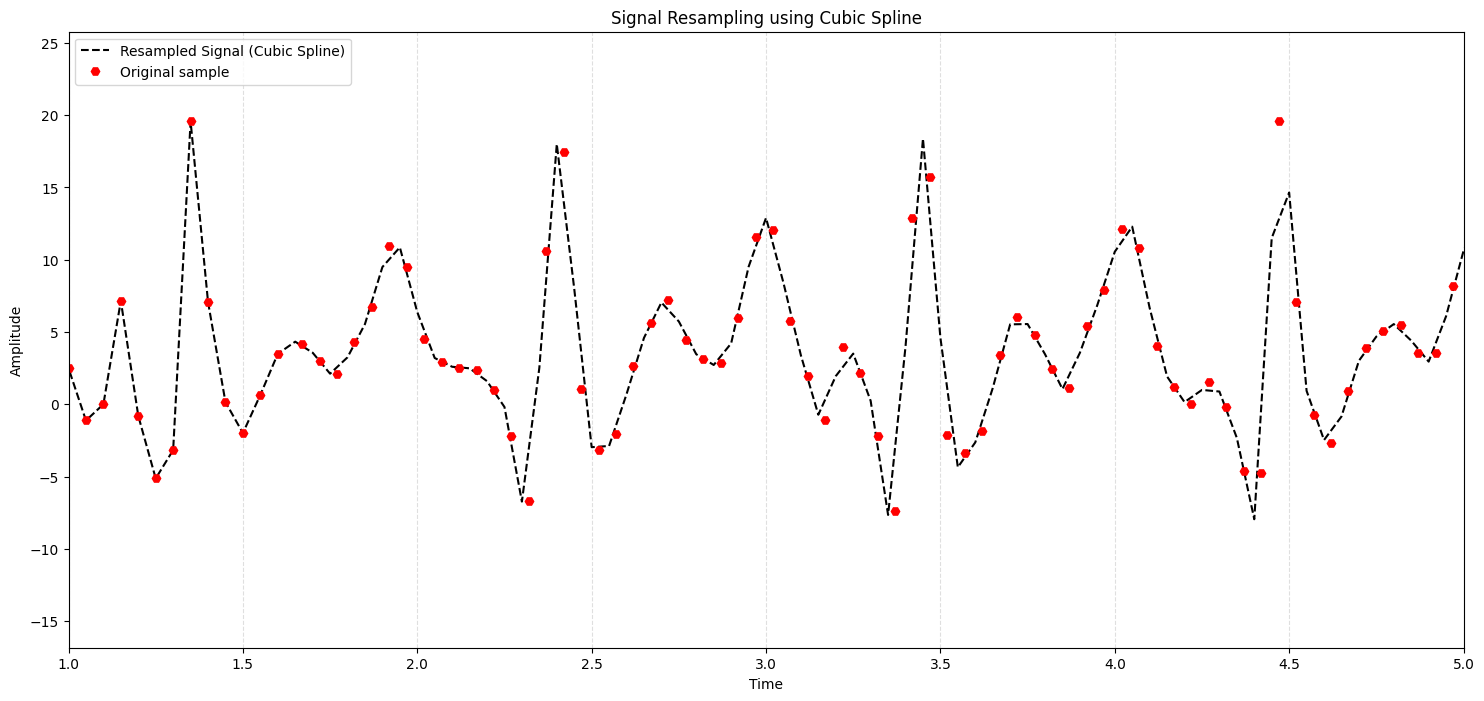

In [ ]:
one_signal = new_df[(new_df["user"] == 1) & (new_df["rec_n"] == 1) & (new_df["activity"] == 'walking')]
one_signal = one_signal.drop_duplicates(subset='time')
sampling_rate = 20
start_time = one_signal['time'].iloc[0]
stop_time = one_signal['time'].iloc[-1]

# crea l'asse x (time) uniforme
Tx = np.arange(start_time, stop_time, 1/(sampling_rate))



resampled_signal = scipy.interpolate.CubicSpline(one_signal['time'], one_signal['gFx'])
resampled_one_signal = resampled_signal(Tx)


plt.figure(figsize=(18,8))
plt.plot(Tx, resampled_one_signal,'black' , linestyle='dashed', label='Resampled Signal (Cubic Spline)')
plt.plot(one_signal['time'], one_signal['gFx'], 'rH', label="Original sample")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper left')
plt.title('Signal Resampling using Cubic Spline')
plt.xlim(1, 5)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()




The plot shows how the cubic spline follows the original sampled signal.

We can now apply the resampling to the whole dataset.

In [ ]:
clean_dfs = []
unique_users_list = wisdm_df['user'].unique().tolist()
activities = ['walking', 'jogging', 'upstairs', 'downstairs', 'sitting', 'standing']

sampling_rate = 20


for user in tqdm(unique_users_list):
    for activity in activities:
        # crea una lista con il numero di recorings per ogni user e activity
        n_recordings = new_df[(new_df['activity'] == activity) & (new_df['user'] == user)]['rec_n'].unique()
        for rec in n_recordings:
            # estrae il singolo segnale
            current_signal = new_df[(new_df['activity'] == activity) & (new_df['user'] == user) & (new_df['rec_n'] == rec)]

            # drop duplicates
            current_signal = current_signal.drop_duplicates(subset='time')

            start_time = current_signal['time'].iloc[0]
            stop_time = current_signal['time'].iloc[-1]

            # crea l'asse x (time) uniforme
            Tx = np.arange(start_time, stop_time, 1/(sampling_rate))

            # crea la spline del segnale corrente per gFx
            cs_x = scipy.interpolate.CubicSpline(current_signal['time'], current_signal['gFx'])

            # crea la spline del segnale corrente per gFy
            cs_y = scipy.interpolate.CubicSpline(current_signal['time'], current_signal['gFy'])

            # crea la spline del segnale corrente per gFz
            cs_z = scipy.interpolate.CubicSpline(current_signal['time'], current_signal['gFz'])


            resampled_ax = cs_x(Tx)
            resampled_ay = cs_y(Tx)
            resampled_az = cs_z(Tx)

            clean_signal = pd.DataFrame({'time': Tx, 'ax': resampled_ax, 'ay': resampled_ay, 'az': resampled_az})
            clean_signal['user'] = user
            clean_signal['activity'] = activity
            clean_signal['rec_n'] = rec

            clean_dfs.append(clean_signal)

clean_df = pd.concat(clean_dfs, ignore_index=True)

100%|██████████| 36/36 [01:06<00:00,  1.83s/it]


Preprocessed data are now stored locally in a pickle format.

In [ ]:
# with open('/work/cleaned_dataframe.pkl', 'wb') as handle:
#     # pickle.dump(clean_df, handle)
#     clean_df.to_pickle('/work/cleaned_dataframe.pkl')

We can observe the amount of recordings for each user and type using a group by.

In [ ]:
user_stats = clean_df.copy()
user_stats = user_stats.pivot_table(index='user', columns='activity', values='rec_n', aggfunc='count', fill_value=0)
user_stats['user'] = user_stats.index
user_stats

activity,downstairs,jogging,sitting,standing,upstairs,walking,user
user,,,,,,,
1,2939,11055,0,0,3120,12860,1
2,0,11785,0,0,0,11738,2
3,3323,11017,1608,2823,3410,12968,3
4,1791,895,1256,0,1376,6079,4
5,3278,6405,1664,1515,3385,12258,5
6,1427,11814,1679,708,1664,12388,6
7,2256,9343,2527,2364,3598,11032,7
8,3347,10306,2698,3269,4450,17106,8
9,0,0,0,0,0,12923,9


The following function takes activity, user and rec number as input, and outputs the selected signal.

In [ ]:
def extract_signal(df, activity=None, user=None, rec_n=None):
    """
    Extracts a signal from the DataFrame based on optional activity, user, and rec_n.

    Parameters:
    - df: DataFrame containing the data.
    - activity: Optional activity parameter (default is None).
    - user: Optional user parameter (default is None).
    - rec_n: Optional rec_n parameter (default is None).

    Returns:
    - DataFrame containing the filtered signal.
    """


    if user is not None and user not in df['user'].unique():
        raise ValueError(f"User '{user}' does not exist in the DataFrame.")
    else:
        conditions = (df['user'] == user) if user is not None else True

        if activity is not None and activity not in df[df['user'] == user]['activity'].unique():
            raise ValueError(f"Activity '{activity}' does not exist in the DataFrame.")
        else:
            conditions &= (df['activity'] == activity) if activity is not None else True

            if rec_n is not None and rec_n not in df[(df['user'] == user) & (df['activity'] == activity)]['rec_n'].unique():
                raise ValueError(f"Rec_n '{rec_n}' does not exist in the DataFrame.")
            else:
                conditions &= (df['rec_n'] == rec_n) if rec_n is not None else True


    return df[conditions]

We will choose the first sitting recording for user 20 and plot the three axes

In [ ]:
# Choose Activity, User and rec_n

activity = 'sitting'
user = 20
rec_n = 1

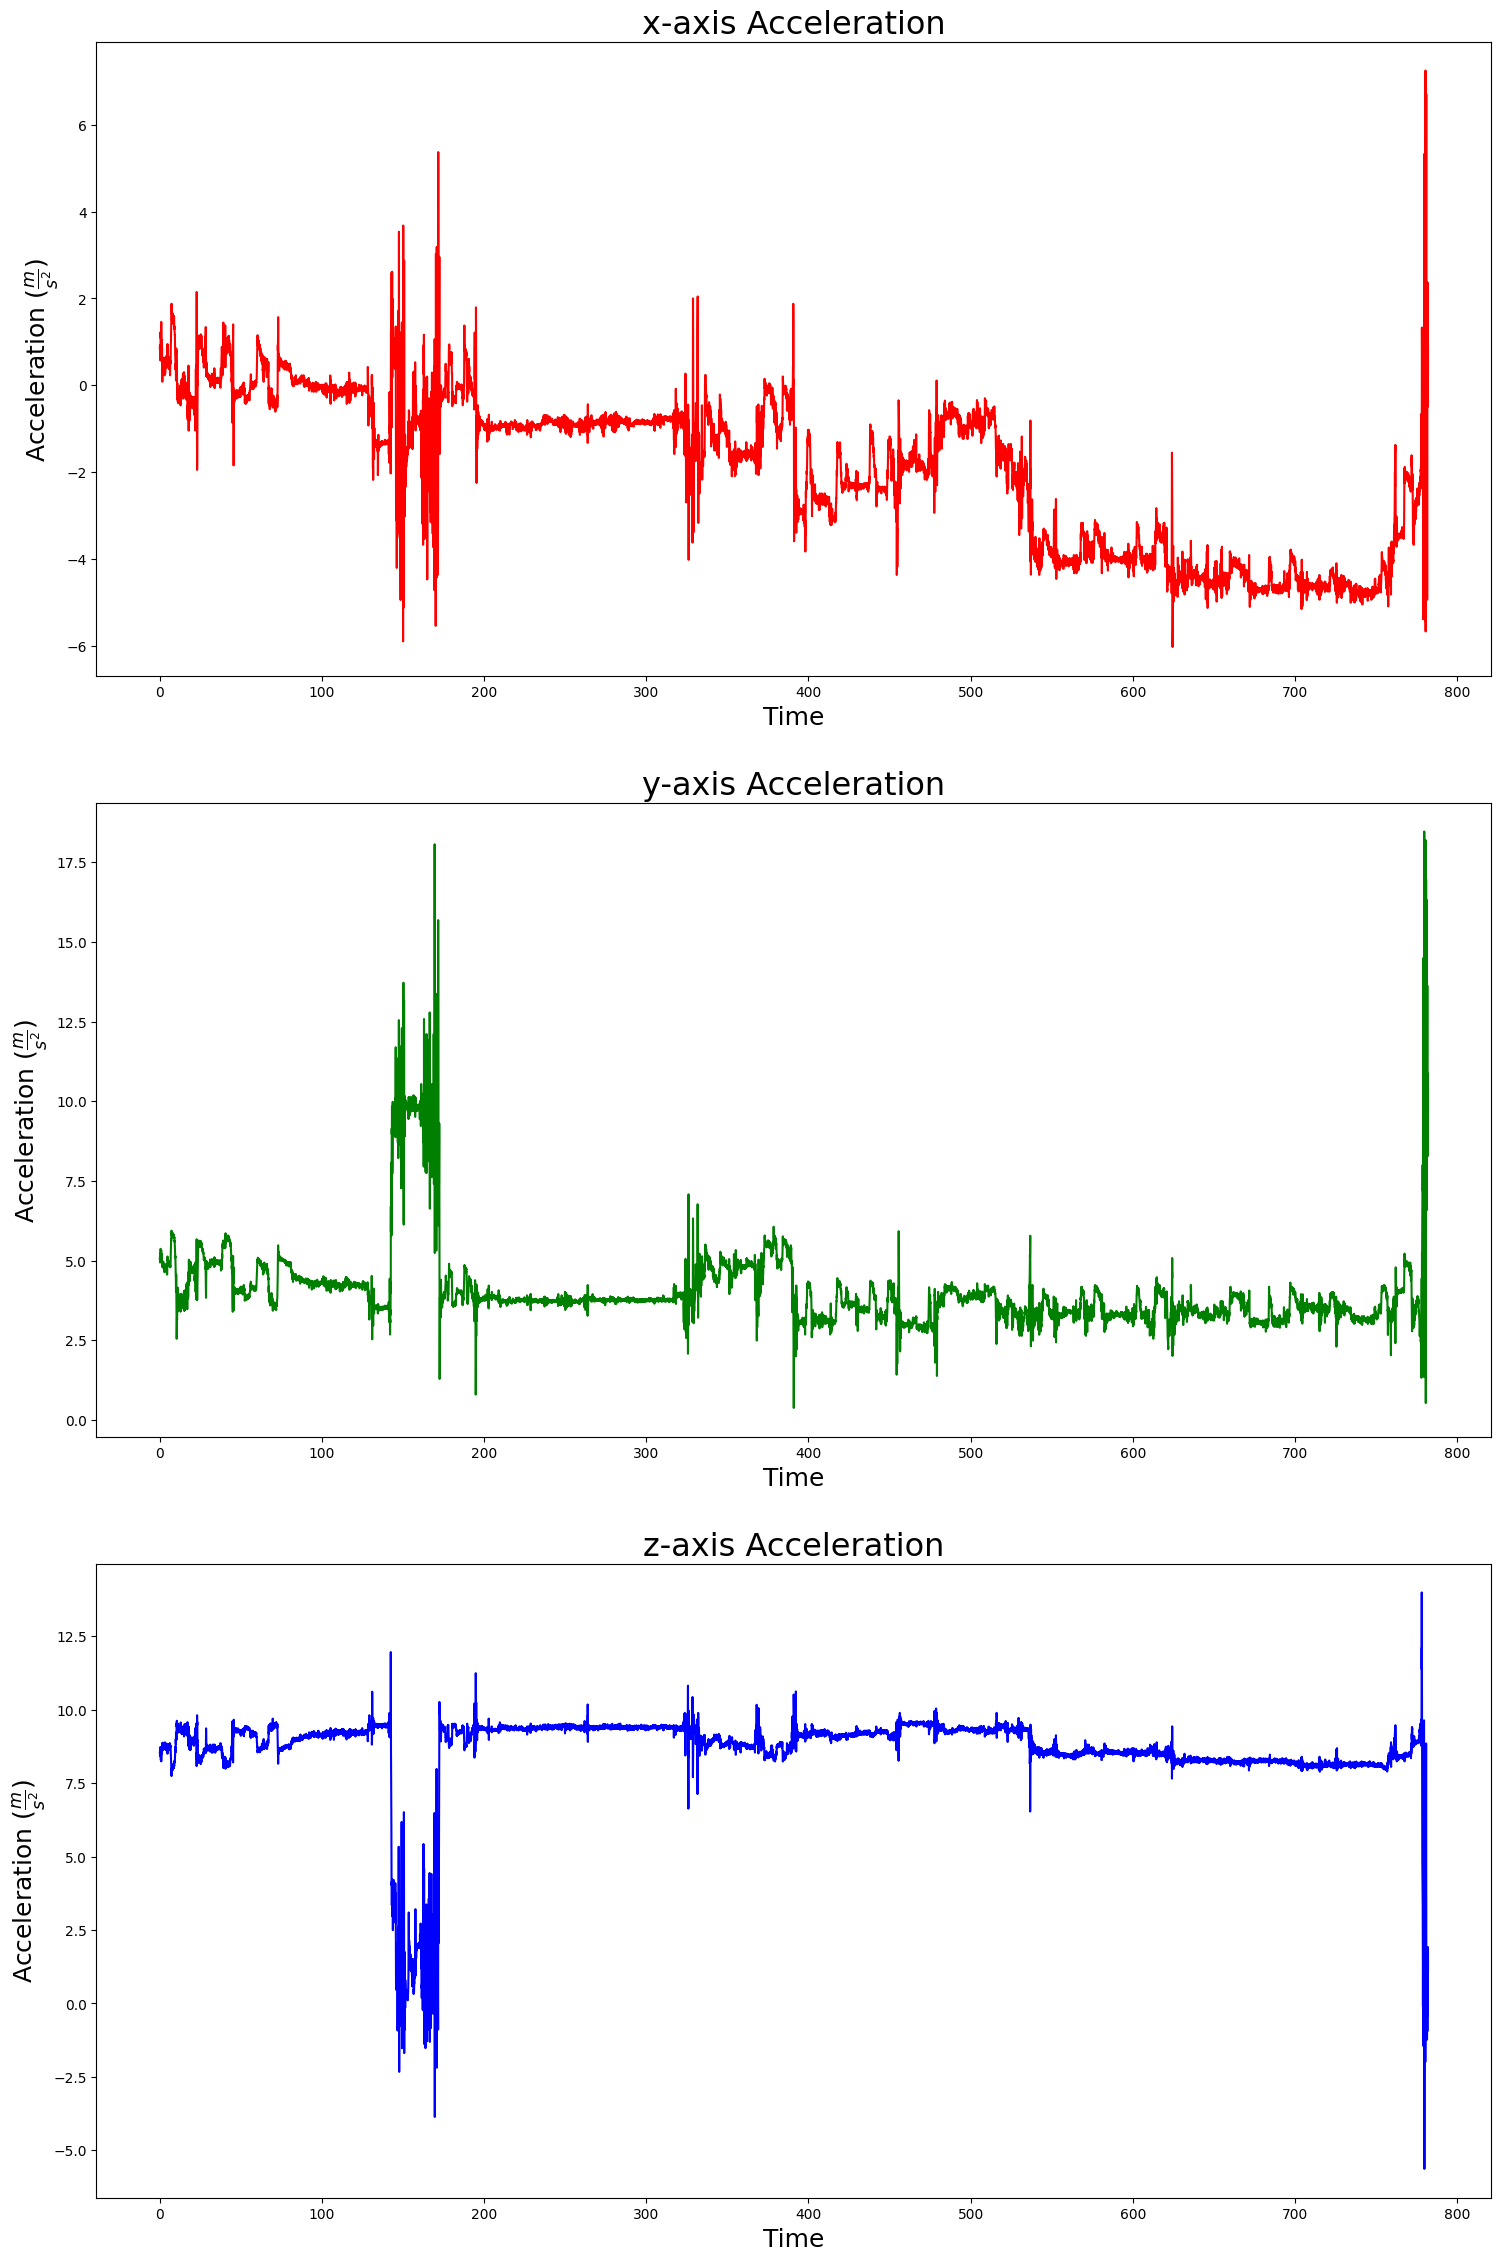

In [ ]:
current_signal = extract_signal(clean_df, activity, user, rec_n)


fig, ax = plt.subplots(3,1, figsize=(18,28))

label_fontsize = 18

ax[0].plot(current_signal['time'], current_signal['ax'], 'r')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[1].plot(current_signal['time'], current_signal['ay'], 'g')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[2].plot(current_signal['time'], current_signal['az'], 'b')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

# plt.tight_layout()
plt.show()


We can use these plots to observe the behaviors of the signals and how they change when the activity changes.

In [ ]:
current_signal

,time,ax,ay,az,user,activity,rec_n
596582,0.00,0.840000,5.050000,8.540000,20,sitting,1
596583,0.05,0.929957,5.129951,8.469966,20,sitting,1
596584,0.10,0.690027,4.940007,8.429985,20,sitting,1
596585,0.15,0.649891,5.009969,8.619959,20,sitting,1
596586,0.20,0.930016,5.010003,8.539950,20,sitting,1
...,...,...,...,...,...,...,...
612221,781.95,1.230176,8.280055,1.610074,20,sitting,1
612222,782.00,0.267306,8.470656,1.919744,20,sitting,1
612223,782.05,-0.380100,8.689860,1.310063,20,sitting,1
612224,782.10,0.689850,9.379891,1.839932,20,sitting,1


In [ ]:
listed_signals = clean_df.groupby(['user', 'activity','rec_n']).agg({
    'ax': lambda x: x.tolist(),
    'ay': lambda x: x.tolist(),
    'az': lambda x: x.tolist()
    })

listed_signals

ax  \
user activity   rec_n                                                      
1    downstairs 1      [-0.15, 0.10899778195053465, -4.05976732002392...   
                2      [4.63, 2.1493673759532848, 0.00016096910079749...   
                3      [0.11, -1.1785283629042935, 6.0162459280662, 6...   
                4      [10.57, 1.7317944810099972, -0.949798866317831...   
     jogging    1      [4.48, 3.950597739961058, 6.049999813965895, 5...   
...                                                                  ...   
36   upstairs   1      [1.46, 0.5692188967659891, -2.029427185236753,...   
                2      [-6.21, -3.4904064224401474, -2.56017123778174...   
                3      [-0.42, -1.0397176828580266, -1.42022182881646...   
                4      [-3.3, -2.9581653611607455, -0.458924453754813...   
     walking    1      [-2.87, -1.7598047554377516, -1.79999872422588...   

                                                                      ay  \
user activity   rec_n                                                      
1    downstairs 1      [9.15, 9.18957680825768, 7.400111195427876, 7....   
                2      [11.88, 11.989928116343656, 10.340416356531215...   
                3      [4.63, 4.3710402389710445, 9.187602872135201, ...   
                4      [10.38, 9.922847040536402, 3.210243240897343, ...   
     jogging    1      [14.18, 12.259418488131782, 9.720295438268344,...   
...                                                                  ...   
36   upstairs   1      [8.5, 9.919868625525162, 9.299655456570097, 10...   
                2      [6.74, 9.528859526313665, 11.110118709846533, ...   
                3      [12.68, 11.600269139211141, 10.082046033072205...   
                4      [13.87, 11.22003842050078, 12.260592116110368,...   
     walking    1      [10.46, 10.039923025103601, 10.120186110014044...   

                                                                      az  
user activity   rec_n                                                     
1    downstairs 1      [-0.34, 2.7606136465778395, 4.020049755417406,...  
                2      [3.72, 10.189564905206613, 3.7211169078979447,...  
                3      [0.34, 0.27069842757170726, 2.410377075326368,...  
                4      [-0.69, 2.3678763902875146, 5.860110161550585,...  
     jogging    1      [-2.11, -2.6796223186910266, -1.94980699331832...  
...                                                                  ...  
36   upstairs   1      [0.84446156, 1.1162793567810987, -1.2247558651...  
                2      [6.973618, 6.851694937544065, 4.33159418601903...  
                3      [0.6537767, 1.0758397783749611, 1.457209798710...  
                4      [2.2201166, 0.9263067294066646, 0.993903127446...  
     walking    1      [0.23154591, -0.532029774881305, -1.0348115724...  

[428 rows x 3 columns]

We can plot the signal lengths in seconds: we observe that signals can have different lengths.  

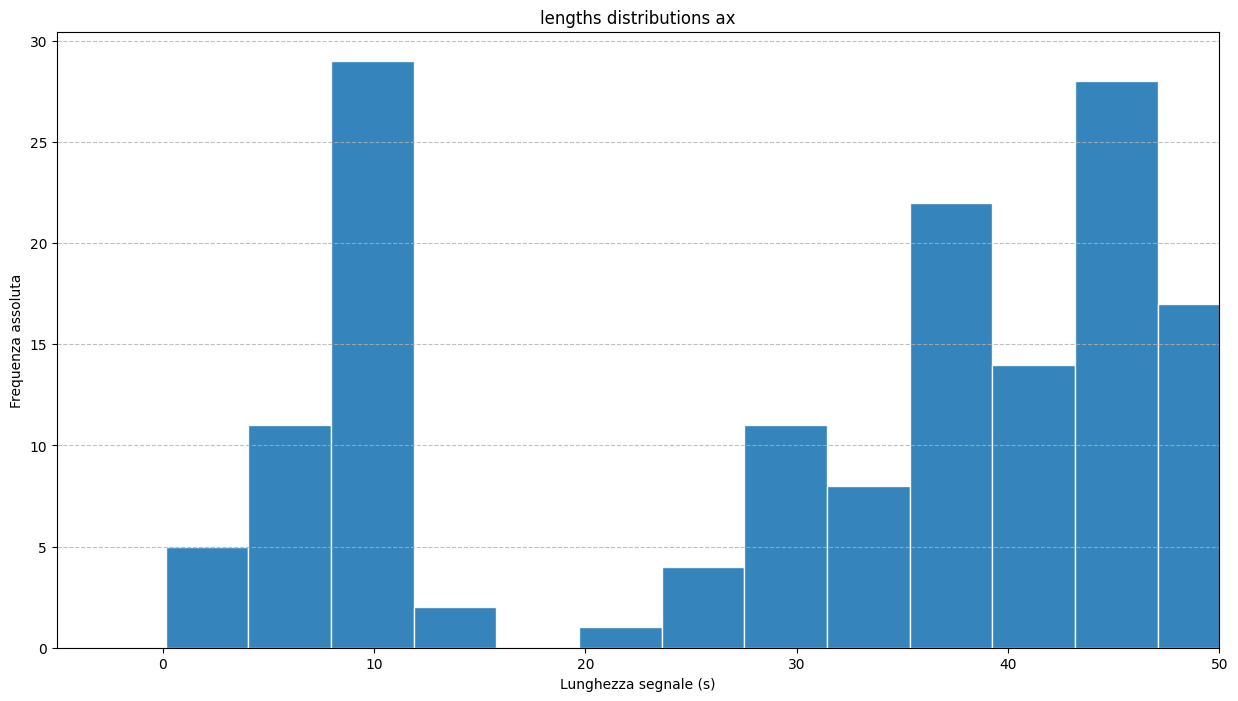

In [ ]:
listed_signals = clean_df.groupby(['user', 'activity','rec_n']).agg({
    'ax': lambda x: x.tolist(),
    'ay': lambda x: x.tolist(),
    'az': lambda x: x.tolist()
    })

lengths_x = [len(arr)/20 for arr in listed_signals['ax']]


# plt.figure(figsize=(6,8))
plt.figure(figsize=(15,8))

plt.hist(lengths_x, bins=200, edgecolor='white', alpha=0.9)
plt.title("lengths distributions ax")


plt.xlabel('Lunghezza segnale (s)')
plt.ylabel('Frequenza assoluta')
plt.xlim([-5, 50])

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.show()

plt.show()

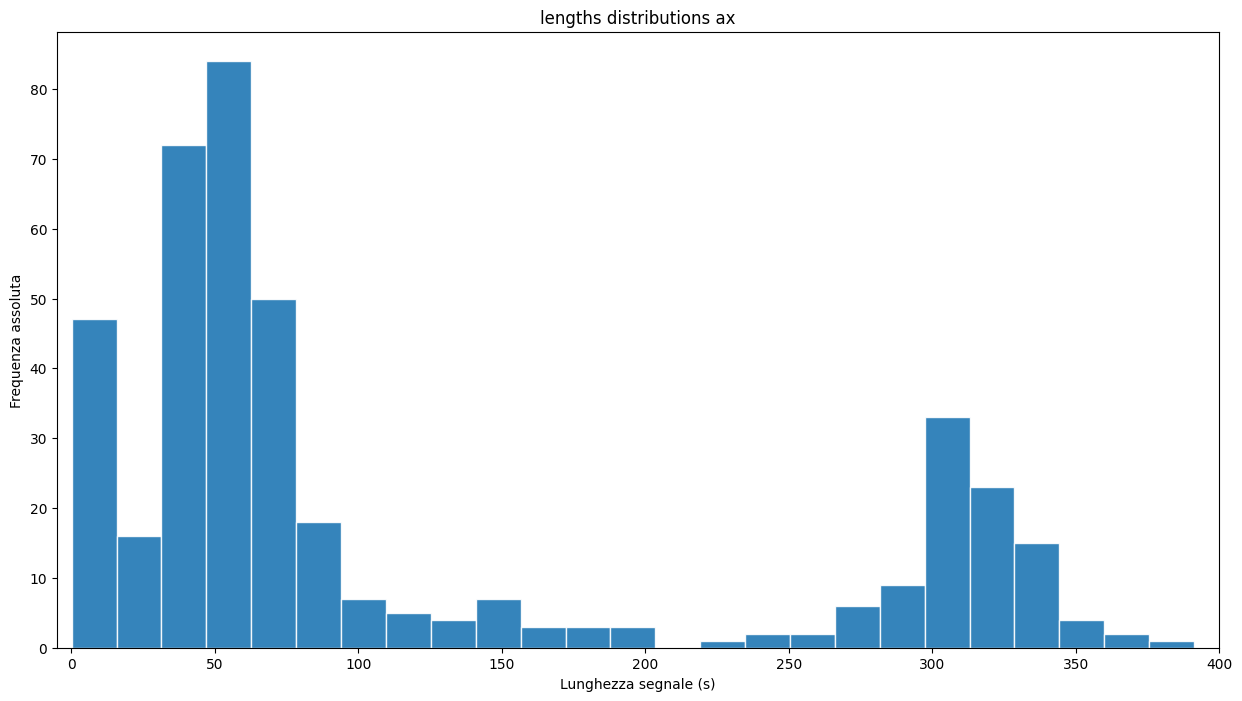

In [ ]:
plt.figure(figsize=(15,8))

plt.hist(lengths_x, bins=50, edgecolor='white', alpha=0.9)
plt.title("lengths distributions ax")


plt.xlabel('Lunghezza segnale (s)')
plt.ylabel('Frequenza assoluta')
plt.xlim([-5, 400])

plt.show()

We have lots of walking and jogging recordings, while classes like sitting and standing are a bit underrepresented.

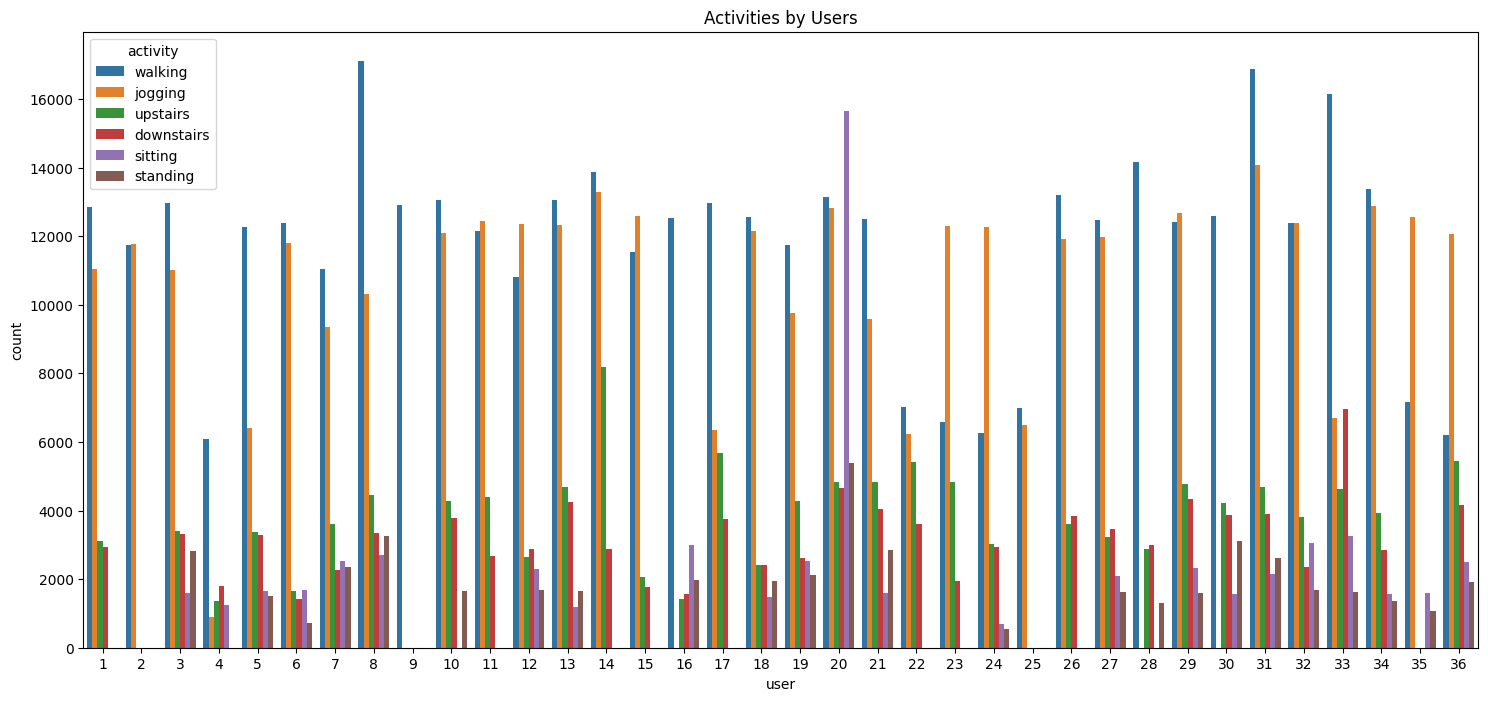

In [ ]:
plt.figure(figsize=(18,8))
sns.countplot(x = 'user',  hue = 'activity', data = clean_df)
plt.title('Activities by Users')
plt.show()

For each user we can observe which activities are provided and how long the recordings are.